# Step 1: Import Required Libraries
This step loads all necessary libraries for preprocessing, model creation, and training.

In [9]:
import os
from collections import Counter

def verify_dataset_structure(base_path):
    print(f"\n🔍 Verifying structure in: {base_path}")
    
    # Check if the base path exists
    if not os.path.exists(base_path):
        print("❌ Error: Path does not exist.")
        return
    
    # List class folders
    class_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    print(f"✅ Found {len(class_folders)} class folders: {class_folders}")
    
    # Count files in each class
    file_counter = Counter()
    total_files = 0

    for class_folder in class_folders:
        class_path = os.path.join(base_path, class_folder)
        png_files = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]
        count = len(png_files)
        file_counter[class_folder] = count
        total_files += count
        print(f"📁 {class_folder} -> {count} .png files")

    print(f"🧮 Total image files in {base_path}: {total_files}")
    return file_counter

# Run verification
train_counts = verify_dataset_structure("E:/final_dataset/train")
val_counts = verify_dataset_structure("E:/final_dataset/val")



🔍 Verifying structure in: E:/final_dataset/train
✅ Found 7 class folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']
📁 angry -> 1578 .png files
📁 disgust -> 1582 .png files
📁 fear -> 1588 .png files
📁 happy -> 1594 .png files
📁 neutral -> 1352 .png files
📁 sad -> 1591 .png files
📁 surprised -> 184 .png files
🧮 Total image files in E:/final_dataset/train: 9469

🔍 Verifying structure in: E:/final_dataset/val
✅ Found 7 class folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']
📁 angry -> 466 .png files
📁 disgust -> 469 .png files
📁 fear -> 468 .png files
📁 happy -> 471 .png files
📁 neutral -> 401 .png files
📁 sad -> 466 .png files
📁 surprised -> 69 .png files
🧮 Total image files in E:/final_dataset/val: 2810


# Step 2: Set Dataset Path and Parameters
Define dataset directory and relevant constants.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [10]:
import tensorflow as tf

# Paths
train_path = "E:/final_dataset/train"
val_path = "E:/final_dataset/val"

# Constants
IMG_SIZE = (96, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Extract class names BEFORE prefetching
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes ({num_classes}): {class_names}")

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 9469 files belonging to 7 classes.
Found 2810 files belonging to 7 classes.
Classes (7): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']


# Step 3: Data Augmentation and Preprocessing
Apply preprocessing and augmentation for training and validation data.

In [3]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Step 4: Load and Preprocess the Dataset
Use `image_dataset_from_directory` to load train and validation datasets.

In [4]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Rescaling(1./127.5, offset=-1),  # Same as preprocess_input
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\ALL\AppData\Local\Temp\ipykernel_9264\301511100.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 3, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 5: Configure Performance Settings
Configure dataset for performance using caching and prefetching.

In [5]:
checkpoint = ModelCheckpoint("E:/mobilenet_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stop, reduce_lr]


# Step 6: Load MobileNetV2 Base Model
Load pretrained MobileNetV2 without top layer and freeze its weights.

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 101s 324ms/step - accuracy: 0.3251 - loss: 1.7889 - val_accuracy: 0.5285 - val_loss: 1.1974 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 314ms/step - accuracy: 0.4831 - loss: 1.2931 - val_accuracy: 0.5512 - val_loss: 1.1290 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 314ms/step - accuracy: 0.5153 - loss: 1.2135 - val_accuracy: 0.5819 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 4/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 114s 385ms/step - accuracy: 0.5354 - loss: 1.1769 - val_accuracy: 0.5936 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 5/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 121s 314ms/step - accuracy: 0.5376 - loss: 1.1587 - val_accuracy: 0.6011 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 6/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 313ms/step - accuracy: 0.5566 - loss: 1.1237 - val_accuracy: 0.6004 - val_loss: 1.0157 - learning_rate: 0.0010
Epoch 7/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 314ms/step - accuracy: 

# Step 7: Add Custom Classification Head
Add global average pooling and dense output layer to MobileNetV2 base.

In [7]:
# STEP 7: Unfreeze base model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: add early stopping and checkpointing
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Retrain with unfrozen model
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.2713 - loss: 1.8425 - val_accuracy: 0.5206 - val_loss: 1.1670
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.4084 - loss: 1.4800 - val_accuracy: 0.4744 - val_loss: 1.3609
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.4851 - loss: 1.2903 - val_accuracy: 0.4594 - val_loss: 1.4674
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.5252 - loss: 1.2049 - val_accuracy: 0.4783 - val_loss: 1.3999


In [16]:
# Print final validation accuracy from history
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


Final Validation Accuracy: 51.00%


# Step 8: Compile the Model
Define optimizer, loss function, and evaluation metrics.

In [19]:
# Save the trained model in Keras native format (.keras)
model.save("E:/mobilenet_best_model.keras")


# Step 9: Define Callbacks
Use callbacks like EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint.

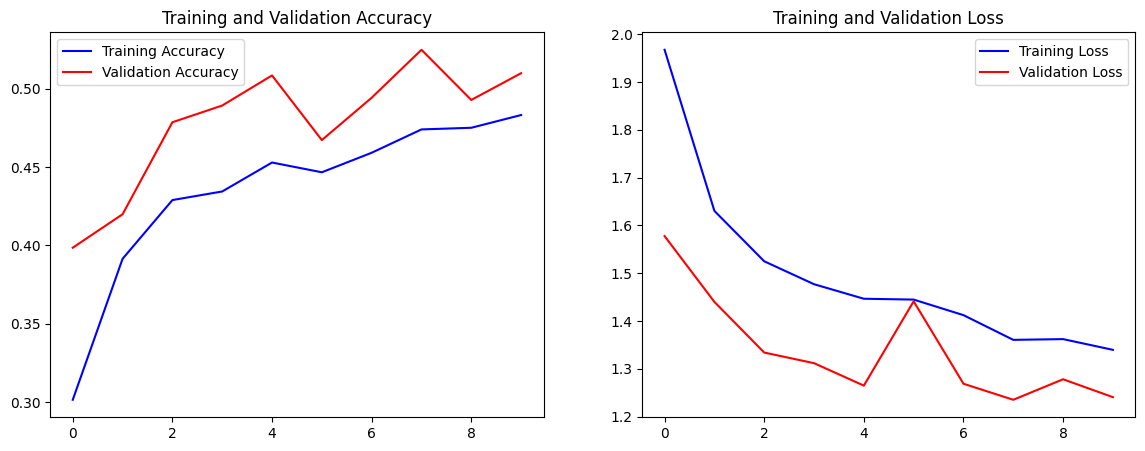

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Accuracy & Loss Graphs ---
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:/final_dataset/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False  # Important: for alignment of labels with predictions
)

# Save class names before any further dataset processing
class_names = val_ds.class_names

# Now add prefetching or other steps
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2810 files belonging to 7 classes.


# Step 10: Train the Model
Fit the model using training and validation datasets.

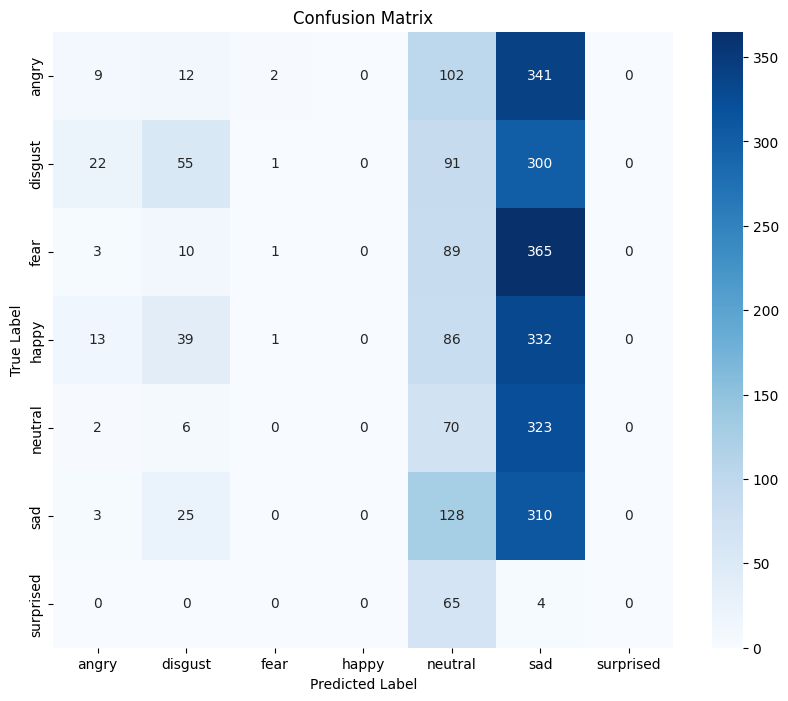


Classification Report:

              precision    recall  f1-score   support

       angry       0.17      0.02      0.03       466
     disgust       0.37      0.12      0.18       469
        fear       0.20      0.00      0.00       468
       happy       0.00      0.00      0.00       471
     neutral       0.11      0.17      0.14       401
         sad       0.16      0.67      0.25       466
   surprised       0.00      0.00      0.00        69

    accuracy                           0.16      2810
   macro avg       0.15      0.14      0.09      2810
weighted avg       0.17      0.16      0.10      2810



C:\Users\ALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [24]:
import os
import random
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_on_sample_images(folder, model, class_names, img_size=(180, 180), count=5):
    """
    Predicts emotion classes for random spectrograms from your dataset folder.

    Parameters:
    - folder (str): Path to your dataset (e.g., "E:/final_dataset/val")
    - model: Trained Keras model
    - class_names (list): List of class names in the same order as training
    - img_size (tuple): Image size (should match model input size)
    - count (int): Number of random predictions to show
    """

    print(f"\nPredictions on {count} random samples:\n")
    for _ in range(count):
        # Pick a random class folder
        class_dir = random.choice(os.listdir(folder))
        class_path = os.path.join(folder, class_dir)

        # Pick a random image from that folder
        image_file = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_file)

        # Load and preprocess the image
        img = load_img(image_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, height, width, channels)

        # Predict
        prediction = model.predict(img_array, verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Print result
        print(f"Image: {image_file}")
        print(f"Actual Emotion: {class_dir}")
        print(f"Predicted Emotion: {predicted_label}")
        print("-" * 40)


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:/final_dataset/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False  # Important for predictions
)

# Save class names BEFORE prefetching
class_names = val_ds.class_names

# Add prefetching after saving class names
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2810 files belonging to 7 classes.


In [3]:
from tensorflow import keras

# Load the trained model in Keras native format
model = keras.models.load_model("E:/mobilenet_best_model.keras")


In [7]:
import os

class_names = sorted(os.listdir("E:/final_dataset/val"))
print("Class names:", class_names)


Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']


In [8]:
import os, random
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_on_sample_images(folder, model, class_names, img_size, count=5):
    files = []
    for root, dirs, filenames in os.walk(folder):
        for filename in filenames:
            if filename.lower().endswith(".png"):
                files.append(os.path.join(root, filename))

    sampled_files = random.sample(files, count)
    results = []

    for img_path in sampled_files:
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array, verbose=0)
        predicted_class = class_names[np.argmax(pred)]

        # Extract actual label from folder name
        actual_class = os.path.basename(os.path.dirname(img_path))

        results.append({
            "filename": os.path.basename(img_path),
            "actual": actual_class,
            "predicted": predicted_class
        })

    return results


# Step 11: Evaluate the Model
Evaluate model performance on the validation dataset.

In [11]:
import pandas as pd

# Step 1: Run the function
results = predict_on_sample_images(
    folder="E:/final_dataset/val",
    model=model,
    class_names=class_names,
    img_size=IMG_SIZE,
    count=5
)

# Step 2: Add correctness
for r in results:
    r["is_correct"] = r["actual"] == r["predicted"]

# Step 3: Convert to DataFrame
df_results = pd.DataFrame(results)

# Step 4: Show results
print(df_results)

# Step 5: Accuracy summary
accuracy = df_results["is_correct"].mean() * 100
print(f"\nAccuracy on {len(df_results)} samples: {accuracy:.2f}%")

# Step 6 (Optional): Save to CSV
df_results.to_csv("E:/prediction_summary.csv", index=False)
print("Saved to E:/prediction_summary.csv")


                   filename     actual  predicted  is_correct
0       1090_ITS_SAD_XX.png        sad        sad        True
1       1059_IEO_FEA_MD.png       fear    neutral       False
2       YAF_seize_angry.png      angry    neutral       False
3       1084_ITS_FEA_XX.png       fear    neutral       False
4  03-01-08-01-02-02-02.png  surprised  surprised        True

Accuracy on 5 samples: 40.00%
Saved to E:/prediction_summary.csv
